In [1]:
#Importing the Libraries
import pandas as pd
import numpy as np

#For Graphs
import matplotlib.pyplot as plt

import common as c #Importing from our common file

pd.options.display.max_columns = None
%matplotlib inline

#pd.set_option('use_inf_as_na', True) 
import seaborn as sns #For HeatMap

#Sklearn Modules
from sklearn.linear_model import Lasso, LogisticRegression
from sklearn.feature_selection import SelectFromModel
from sklearn.preprocessing import StandardScaler


In [3]:
#Importing the datasets
nursing,rating = c.fetch_both_data()


In [4]:
len(set(rating["Federal Provider Number"]))==len(rating["Federal Provider Number"])

True

This shows that all the Federal Provider Number are unique

In [5]:
dic2 = {}
for i in ["Overall Rating","Health Inspection Rating","QM Rating","Staffing Rating","RN Staffing Rating"]:
    dic2[i] = c.find_top_n_features(nursing,rating,rpm=i,n=11,threshold=None)    

Final Number of Feature Selected 10


In [6]:
#Code to find the features that are affects all types of Star Rating 
ans = []
for i in dic2:
    X_transform,scaler,name_features,threshold = dic2[i]
    ans.append(name_features)
from functools import reduce
list(reduce(set.intersection, [set(item) for item in ans ]))

['Staff Total Confirmed COVID-19', 'Number of All Beds']

In [7]:
cols = ["Overall Rating","Health Inspection Rating","QM Rating","Staffing Rating","RN Staffing Rating"]

In [8]:
feature_list = pd.Series(list(nursing.columns))

In [9]:
#Creating mxn Dataframe
data = np.array([np.zeros(len(feature_list))]*len(cols)).T
df = pd.DataFrame(data, index=feature_list, columns=cols)

In [10]:
#Populating the Matrix
for i in dic2:
    X_transform,scaler,name_features,threshold = dic2[i]
    for j in name_features:
        df[i][j] = 1

In [11]:
df['Feature sum'] = df[cols].sum(axis=1)

In [12]:
ignored = ['Week Ending', 'Federal Provider Number', 'Provider Name',
       'Provider Address', 'Provider City', 'Provider State',
       'Provider Zip Code','Geolocation','County']
try:
    df= df.drop(ignored)
except:
    print("Column not found")

In [13]:
#Manual Classification done by me (Based on intution, Just to verify insights)
resident = ['Residents Weekly Admissions COVID-19',
            'Residents Total Admissions COVID-19',
            'Residents Weekly Confirmed COVID-19',
            'Residents Total Confirmed COVID-19',
            'Residents Weekly Suspected COVID-19',
            'Residents Total Suspected COVID-19',
            'Residents Weekly All Deaths',
            'Residents Total All Deaths',
            'Residents Weekly COVID-19 Deaths',
            'Residents Total COVID-19 Deaths',
            'Resident Access to Testing in Facility']

staffing = ['Staff Weekly Confirmed COVID-19', 'Staff Total Confirmed COVID-19',
           'Staff Weekly Suspected COVID-19', 'Staff Total Suspected COVID-19',
           'Staff Weekly COVID-19 Deaths', 'Staff Total COVID-19 Deaths',
           'Shortage of Nursing Staff', 'Shortage of Clinical Staff','Shortage of Aides', 'Shortage of Other Staff']
supply = [ 'Any Current Supply of N95 Masks', 'One-Week Supply of N95 Masks',
           'Any Current Supply of Surgical Masks',
           'One-Week Supply of Surgical Masks',
           'Any Current Supply of Eye Protection',
           'One-Week Supply of Eye Protection', 'Any Current Supply of Gowns',
           'One-Week Supply of Gowns', 'Any Current Supply of Gloves',
           'One-Week Supply of Gloves', 'Any Current Supply of Hand Sanitizer',
           'One-Week Supply of Hand Sanitizer', 'Ventilator Dependent Unit',
           'Number of Ventilators in Facility',
           'Number of Ventilators in Use for COVID-19',
           'Any Current Supply of Ventilator Supplies',
           'One-Week Supply of Ventilator Supplies']


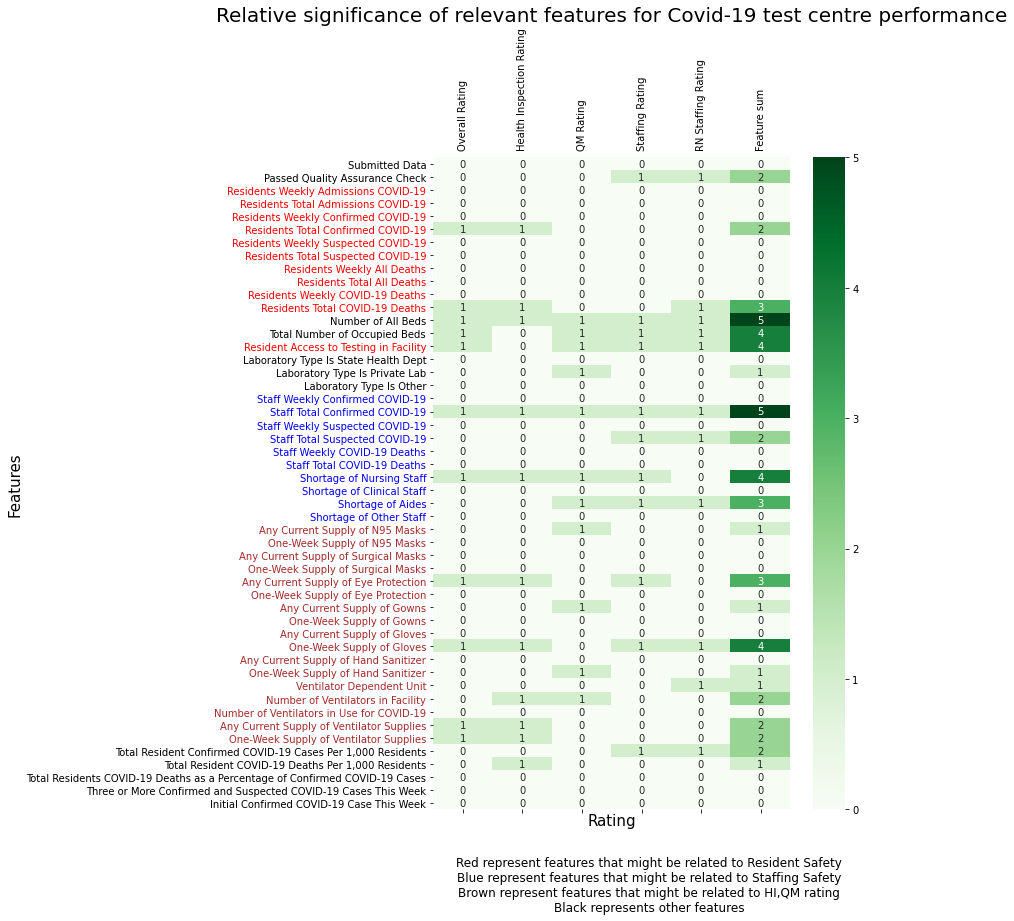

In [14]:
#Plotting the HeatMap
plt.figure(figsize=(8, 12))
ax = sns.heatmap(df, annot=True,cmap="Greens")
for l in ax.xaxis.get_ticklabels()+ax.yaxis.get_ticklabels():
    if l.get_text() in resident:
        l.set_color('r')
    if l.get_text() in staffing:
        l.set_color('b')
    if l.get_text() in supply:
        l.set_color('brown')
ax.set_title('Relative significance of relevant features for Covid-19 test centre performance',fontsize = 20) 
ax.set_xlabel('Rating',fontsize = 15)
ax.set_ylabel('Features',fontsize = 15)
ax.tick_params(labeltop=True,labelbottom=False)
plt.xticks(rotation='vertical')
txt="Red represent features that might be related to Resident Safety\nBlue represent features that might be related to Staffing Safety\nBrown represent features that might be related to HI,QM rating\nBlack represents other features"
plt.figtext(0.5, 0.01, txt, wrap=True, horizontalalignment='center', fontsize=12)
plt.show()

## Basic Insights from Heatmap

- Resident factor selected one 
- Shortage of nursing staff is very important vectpr
- Total Resident COVID-19 Deaths Per 1,000 Residents is imp but not very much
- one week supply of gown is not important rather than one week supply of gloves
- Shortage of aides is seems important 
- Total Number of Occupied Beds, Number of All Beds
- Resident Access to Testing in Facility, Staff Total Confirmed COVID-19, Shortage of Nursing Staff	
- Current supply of ventilator affects overall rating and in general affects health inspection and QM rating
- Geolocation itself is a separate analysis

In [15]:
#Code to Fetch pre-processed stats of the facility by their Federal Provider Number
X,y = c.fetch_facility(nursing,rating,'015075') 
#Can be used for future purposes to find the specific performance analysis of a single facility

In [16]:
#Divinding the Overall Rating into group and doing a separate analysis
dic = {}
grp = rating.groupby('Overall Rating')
for i,j in grp:
    dic[i] = list(j["Federal Provider Number"])
new = nursing[nursing['Federal Provider Number'].isin(dic[1])]    

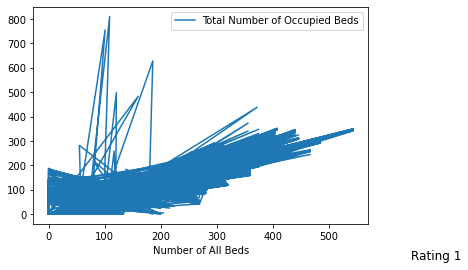

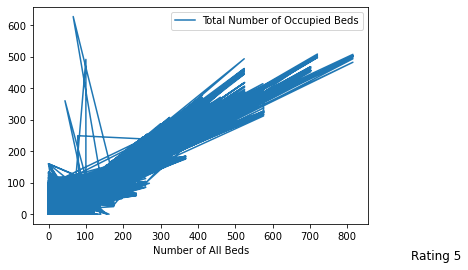

In [23]:
for j in [1,5]:
    new = nursing[nursing['Federal Provider Number'].isin(dic[j])]
    new = new.replace('Y',1)
    new = new.replace('N',0)
    new = new.replace([np.inf, np.nan, -np.inf], 0)
    convert = ["Total Number of Occupied Beds","Number of All Beds",'Total Resident Confirmed COVID-19 Cases Per 1,000 Residents','Total Resident COVID-19 Deaths Per 1,000 Residents','Total Residents COVID-19 Deaths as a Percentage of Confirmed COVID-19 Cases','Staff Weekly Suspected COVID-19','Staff Total Suspected COVID-19','Total Number of Occupied Beds','Residents Total All Deaths']
    for i in convert:
        new[i] = pd.to_numeric(new[i], errors='coerce').fillna(0).astype(int)
    new.plot(x="Number of All Beds",y="Total Number of Occupied Beds")
    txt= "Rating {}".format(j)
    plt.figtext(1, 0.001, txt, wrap=True, horizontalalignment='left', fontsize=12)
    plt.show()

As you can see there is a positive correlation between No. of All beds and Total No. of Occupied Beds. 
The slopes are different at rating 1 and rating 5; therefore, we can get a upper value and lower value of a range;
can be used as a characterisitc key feature for single facility 

In [18]:
#Running Feature Selection process on dataframe divided based on ranking.
data = {}
for j in [1,2,3,4,5]:
    temp = {}
    for k in ["Health Inspection Rating","QM Rating","Staffing Rating","RN Staffing Rating"]:
        new = nursing[nursing['Federal Provider Number'].isin(dic[j])]
        temp[k] = c.find_top_n_features(new,rating,rpm=k,n=11,threshold=None)
    data[j]=temp    

Final Number of Feature Selected 10


In [19]:
len(data)

5

In [20]:
ans=[]
for i in data[1]: 
    X_transform,scaler,name_features,threshold = data[1][i]
    ans.append(name_features)
from functools import reduce
list(reduce(set.intersection, [set(item) for item in ans ]))

['Number of All Beds']

In [21]:
import itertools
merged = list(itertools.chain(*ans))
import collections
counter=collections.Counter(merged)
print(counter)

Counter({'Number of All Beds': 4, 'One-Week Supply of N95 Masks': 3, 'Shortage of Aides': 3, 'Laboratory Type Is State Health Dept': 3, 'Total Number of Occupied Beds': 3, 'Residents Total COVID-19 Deaths': 3, 'Staff Total Confirmed COVID-19': 2, 'One-Week Supply of Gowns': 2, 'Resident Access to Testing in Facility': 2, 'Any Current Supply of N95 Masks': 2, 'Shortage of Nursing Staff': 2, 'Passed Quality Assurance Check': 2, 'Total Resident COVID-19 Deaths Per 1,000 Residents': 1, 'One-Week Supply of Ventilator Supplies': 1, 'Residents Total All Deaths': 1, 'Number of Ventilators in Use for COVID-19': 1, 'Shortage of Other Staff': 1, 'Any Current Supply of Gloves': 1, 'Total Residents COVID-19 Deaths as a Percentage of Confirmed COVID-19 Cases': 1, 'Residents Total Admissions COVID-19': 1, 'Any Current Supply of Ventilator Supplies': 1, 'Residents Total Confirmed COVID-19': 1, 'Staff Total Suspected COVID-19': 1, 'Number of Ventilators in Facility': 1, 'Initial Confirmed COVID-19 Case